In [1]:
import DeltaT as DT
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

## Examples of Delta T calculation with error estimate

In [2]:
DT.DeltaT_with_error_estimate(2018.7)

'69.18 ± 0.05 seconds'

In [3]:
DT.DeltaT_with_error_estimate([-800, 1942.5, 523.6, 2232])

['21769 ± 360 seconds',
 '25.63 ± 0.05 seconds',
 '5364 ± 40 seconds',
 '211 ± 20 seconds']

In [4]:
# Comparison with the second table in http://astro.ukho.gov.uk/nao/lvm/
y = np.arange(-700, 1700, 100)
df = pd.DataFrame({'y':y, 'DeltaT':DT.DeltaT_with_error_estimate(y)})
display(df)

,y,DeltaT
0,-700,20050 ± 170 seconds
1,-600,18468 ± 160 seconds
2,-500,16940 ± 150 seconds
3,-400,15474 ± 130 seconds
4,-300,14081 ± 120 seconds
5,-200,12773 ± 110 seconds
6,-100,11558 ± 100 seconds
7,0,10441 ± 90 seconds
8,100,9405 ± 80 seconds
9,200,8425 ± 70 seconds


In [5]:
# Comparison with the 4th table in http://astro.ukho.gov.uk/nao/lvm/
y = np.arange(1800, 1901, 10)
df = pd.DataFrame({'y':y, 'DeltaT':DT.DeltaT_with_error_estimate(y)})
display(df)

,y,DeltaT
0,1800,18.4 ± 0.5 seconds
1,1810,15.7 ± 0.2 seconds
2,1820,16.5 ± 0.2 seconds
3,1830,10.8 ± 0.2 seconds
4,1840,7.6 ± 0.1 seconds
5,1850,9.3 ± 0.1 seconds
6,1860,9.0 ± 0.1 seconds
7,1870,2.37 ± 0.05 seconds
8,1880,-3.21 ± 0.05 seconds
9,1890,-3.88 ± 0.05 seconds


## Delta T Plot

Plot $\Delta T$ from y=1500 to y=2200

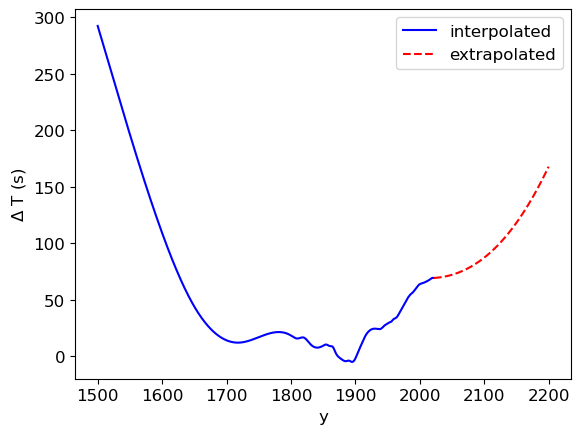

In [6]:
plt.rcParams.update({'font.size': 12})
yint = np.arange(1500,2023)
yext = np.arange(2022, 2201)
plt.plot(yint, DT.DeltaT(yint), '-b', label='interpolated')
plt.plot(yext, DT.DeltaT(yext), '--r', label='extrapolated')
plt.xlabel('y')
plt.ylabel(r'$\Delta$ T (s)')
plt.legend()
plt.show()

## Error of the extrapolation formula for y > 2022

Daily values of $\Delta T$ in 1972 and later can be constructed from the data published in [IERS Bulletin B](https://www.iers.org/IERS/EN/Publications/Bulletins/bulletins.html). 

The csv file `DeltaT_IERS.csv` contains data of $\Delta T$ from Jan 1972 to February 1, 2024 compiled from the IERS files. It has the following columns:
- year, month, day: UT1 date
- MJD: UT1 Julian date number - 2400000.5
- UT1_UTC: Value of UT1 - UTC in sec
- sigma: estimated error of UT1 in sec
- DeltaT: $\Delta T$ computed from (TT - UTC) - (UT1 - UTC) 
           = 42.184s + (accumulated leap seconds) - (UT1 - UTC)

The data in this csv file can be used to calculate the error of the extrapolation formula for Delta T for y > 2022.

Value of y may be obtained from MJD using the fact that the MJD of 2000-Jan-1 0h is 51544 and there are 365.2425 days in a Gregorian year on average:
y = (MJD - 51544)/365.2425 + 2000

In [7]:
df = pd.read_csv("DeltaT_IERS.csv")
df['y'] = (df['MJD'] - 51544)/365.2425 + 2000
df = df[df.y > 2022].copy()
df['eps'] = DT.DeltaT(df['y']) - df['DeltaT']
df[['y','eps']].describe()

,y,eps
count,762.000000,762.000000
mean,2023.043594,0.101857
std,0.602654,0.062329
min,2022.001821,-0.015794
25%,2022.522708,0.053756
50%,2023.043594,0.115023
75%,2023.564481,0.138638
max,2024.085368,0.187965


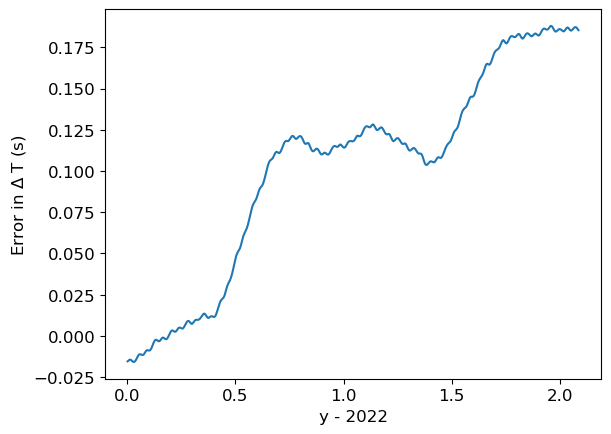

In [8]:
plt.plot(df['y'] - 2022, df['eps'])
plt.xlabel("y - 2022")
plt.ylabel(r"Error in $\Delta$ T (s)")
plt.show()

We see that for y > 2022, the maximum error of the extrapolated $\Delta T$ is 0.188 seconds in magnitude, the mean is 0.102 seconds and std is 0.062 seconds. The root-mean-square error is $\sqrt{0.102^2+0.062^2} = 0.12$ seconds.

## Extension of the Cubic Spline Fit

In the Morrison et al cubic spline fit, $\Delta T$ in an interval $[y_0, y_1]$ is computed by the cubic polynomial 
$$
 \Delta T = a_0 + a_1 t + a_2 t^2 + a_3 t^3 ,
$$
where 
$$
  t = \frac{y - y_0}{y_1-y_0}
$$
and $y_0 = -720, -100, 400, 1000, ..., 2016$, $y_1 = -100, 400, 1000, 1150, ..., 2019$. The original formula is fitted up to the year 2019, but we can extend the cubic spline fit beyond 2019 using the $\Delta T$ data provided by IERS. 

The function `extend_Morrison_etal_cubic_spline(knots)` in `regression_cubic_spline.py` can be used to extend the fit. To do that, we specify new knots at which we will modify the spline. For example, we can set `knots = [2013, 2016, 2019, 2022]` and pass this to `extend_Morrison_etal_cubic_spline()`. The function will fit a new set of cubic polynomials in the intervals $[2013, 2016]$, $[2016, 2019]$ and $[2019, 2022]$ using the IERS data in `DeltaT_IERS.csv`. The cubic polynomials before 2013 will not be changed and the new set of cubic polynomials represent a function that is continuous and so are its first and second derivatives, but the third derivative is discontinuous at the knots.

The `extend_Morrison_etal_cubic_spline()` function will return a tuple containing `spline`, `residuals` and `c2`. `spline` is a dictionary with keys 'y0', 'y1', 'a0', 'a1', 'a2', 'a3', and 'epsilon' for the new cubic spline. `epsilon` is the root mean square error (in seconds) of the fit in the intervals. `c2` is the integration constant that can be used for extrapolation using the integrated lod function for $y$ greater than the last knot.

The following shows a few examples of using the function.

In [9]:
knots = np.arange(2013, 2024, 3)
print(knots)

[2013 2016 2019 2022]


In [10]:
from regression_cubic_spline import extend_Morrison_etal_cubic_spline

def fit_and_display_result(knots):
    spline, residuals, c2 = extend_Morrison_etal_cubic_spline(knots)
    display(pd.DataFrame(spline))
    print('c2 = ',c2)
    # plot residuals of the fit
    plt.plot(residuals['y'], residuals['res'])
    plt.xlabel('y')
    plt.ylabel('Residuals (s)')
    plt.show()

,y0,y1,a0,a1,a2,a3,epsilon
0,2010.0,2013.0,66.061,0.839,-0.109,0.128,0.023328
1,2013.0,2016.0,66.919,1.005,0.275,-0.071,0.034826
2,2016.0,2019.0,68.128,1.341,0.061,-0.281,0.029713
3,2019.0,2022.0,69.248,0.620,-0.782,0.193,0.020854


c2 =  -150.31503510292862


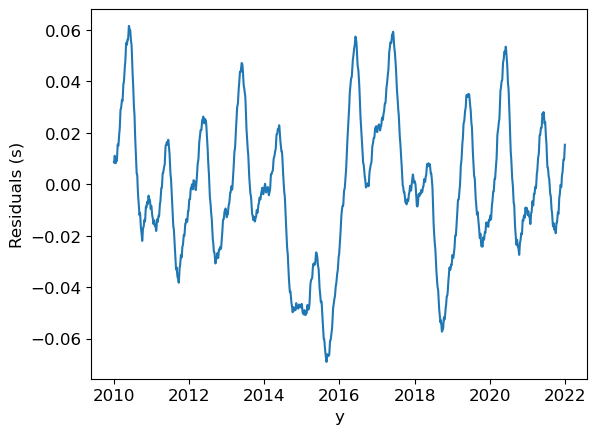

In [11]:
fit_and_display_result(knots)

This is the new cubic spline polynomials currently used in the function `DeltaT()` in `Delta.py`. Note that the coefficients in $[2010,2013]$ are exactly the same as the original Morrison et al cubic spline.

Let's try a different `knots`.

,y0,y1,a0,a1,a2,a3,epsilon
0,2010.0,2012.0,66.061,0.559,-0.048,0.038,0.025573
1,2012.0,2014.0,66.610,0.576,0.065,0.015,0.021965
2,2014.0,2016.0,67.267,0.753,0.112,-0.017,0.028147
3,2016.0,2018.0,68.115,0.927,0.062,-0.125,0.027364
4,2018.0,2020.0,68.978,0.675,-0.314,0.029,0.026035
5,2020.0,2022.0,69.369,0.135,-0.226,-0.011,0.022054


c2 =  -150.32703510292862


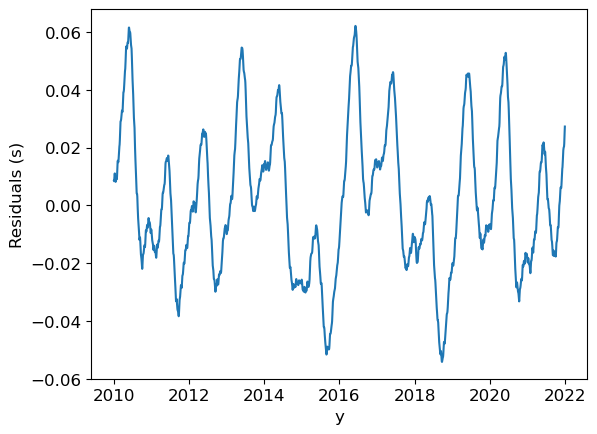

In [12]:
knots = np.arange(2012, 2024, 2)
fit_and_display_result(knots)

Note that the cubic spline in the interval $[2010, 2012]$ is the same as the original, but the coefficients are not the same. This is because the original coefficients are for the variable $t = (y-2010)/(2013-2010)$, whereas the new coefficients are for $t = (y-2010)/(2012-2010)$ and so we have $t \rightarrow 3t/2$, which means $a_1 \rightarrow 2a_1/3$, $a_2 \rightarrow a_2 (2/3)^2 $ and $a_3 \rightarrow a_3 (2/3)^3$.

Let's now extend the spline to the end of the IERS data in `DeltaT_IERS.csv`. The fourth column in the csv file is MJD (= JD - 2400000.5). The last MJD can be obtained easily and the corresponding value of $y$ can be calculated. We will round the value to one decimal place.

In [13]:
mjd_end = np.loadtxt('DeltaT_IERS.csv', delimiter=',', skiprows=1)[-1,3]
yend = round(2000 + (mjd_end - 51544)/365.2425, 1)
print('mjd_end = {}, yend = {}'.format(mjd_end, yend))

mjd_end = 60341.0, yend = 2024.1


In fact, the beginning and end of JD in `DeltaT_IERS.csv` are stored in the variables `jd_beg` and `jd_end` in `DeltaT.py`, and the function `jdy(jd)` can be used to convert `jd` to $y$:

In [14]:
print('mjd_end = {}, yend = {}'.format(DT.jd_end-2400000.5, round(DT.jdy(DT.jd_end), 1)))

mjd_end = 60341.0, yend = 2024.1


Now we can set up `knots` to include the latest IERS data.

In [15]:
knots = np.append(np.arange(2013, yend, 3), yend)
print(knots)

[2013.  2016.  2019.  2022.  2024.1]


,y0,y1,a0,a1,a2,a3,epsilon
0,2010.0,2013.0,66.061,0.839,-0.109,0.128,0.023328
1,2013.0,2016.0,66.919,1.005,0.275,-0.070,0.035131
2,2016.0,2019.0,68.129,1.344,0.064,-0.288,0.029057
3,2019.0,2022.0,69.249,0.607,-0.801,0.241,0.021955
4,2022.0,2024.1,69.295,-0.191,-0.039,0.125,0.020027


c2 =  -150.49080368346523


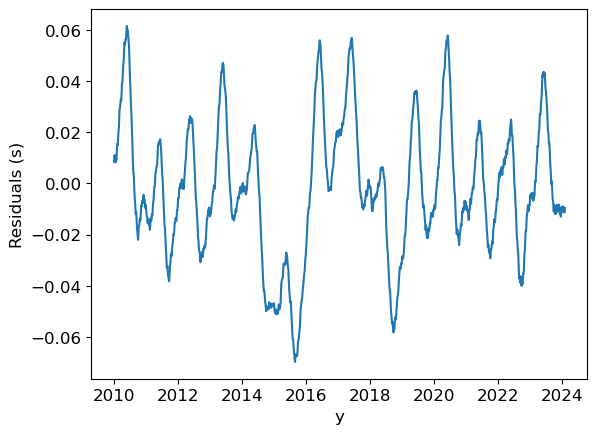

In [16]:
fit_and_display_result(knots)

The extension of the cubic spline fit is a convenient way of updating the $\Delta T$ formula if high precision of $\Delta T$ is not required and the spline coefficients can be updated every few years. If higher precision is required, one would want to interpolate the IERS data directly.

## Compute Delta T from the IERS data

$\Delta T$ can also be computed by interpolating the IERS data in `DeltaT_IERS.csv`. The function `DeltaT_hybrid(jd)` calculates $\Delta T$ at Julian date `jd` using a hybrid method. Inside the IERS data range, the function calculates $\Delta T$ by linear interpolation of the data. Outside the data range, it calculates $\Delta T$ either by the cubic spline polynomials or integrated lod function. The function `DeltaT_hybrid_with_error_estimate(jd)` also provides an estimate of the error in the computed $\Delta T$. This is probably the best method of calculating $\Delta T$ as the most up-to-date $\Delta T$ can be obtained without much effort. All we need to do is to update the IERS data.

Note that the functions use the Julian date as input instead of year, but we can define a continuous year $y$ associated with JD by 
$$
  y = \left \{ \begin{array}{ll} \frac{JD + 0.5}{365.25} - 4712 & JD < 2299160.5 \\ 
  \frac{JD - 2451544.5}{365.2425} + 2000 & JD \geq 2299160.5 \end{array} \right.
$$

This definition takes into account the transition from Julian to Gregorian calendar in 1582, which makes $y$ discontinuous at JD = 2299160.5.

In [17]:
yjd = lambda y: np.where(y > 1582.787, 2451544.5 + (y-2000)*365.2425, (y+4712)*365.25 - 0.5)

In [18]:
y = np.arange(1950,2051,10)
dT = DT.DeltaT_hybrid_with_error_estimate(yjd(y))
display(pd.DataFrame({'y':y, 'Delta T':dT}))

,y,Delta T
0,1950,28.93 ± 0.05
1,1960,33.07 ± 0.05
2,1970,39.93 ± 0.05
3,1980,50.539288 ± 0.0011
4,1990,56.854523 ± 0.00091
5,2000,63.828527 ± 0.00043
6,2010,66.069683 ± 0.00022
7,2020,69.361075 ± 0.00019
8,2030,69.5 ± 1.
9,2040,70.0 ± 4.


The errors in $\Delta T$ inside the IERS data range are much reduced. They are estimated by either the measurement errors of UT1 or half the difference between two values of $\Delta T$ used in the interpolation, whichever is larger.

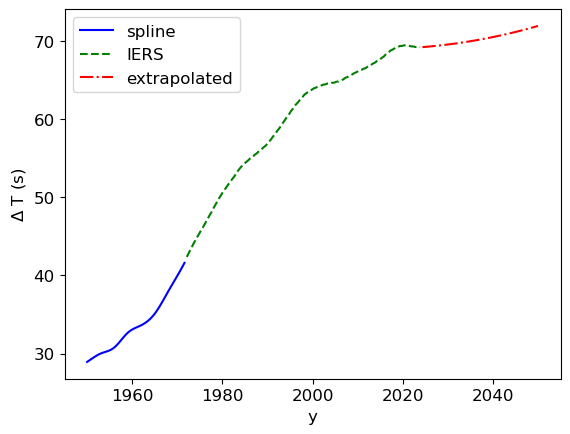

In [19]:
# Plot the hybrid Delta T between 1950 and 2050
y = np.linspace(1950,2050, 200)
dT = DT.DeltaT_hybrid(yjd(y))
y1 = DT.jdy(DT.jd_beg)
y2 = DT.jdy(DT.jd_end)
plt.plot(y[y < y1], dT[y < y1], '-b', label='spline')
plt.plot(y[(y >= y1) & (y < y2)], dT[(y >= y1) & (y < y2)], '--g', label='IERS')
plt.plot(y[y>y2], dT[y>y2], '-.r', label='extrapolated')
plt.xlabel('y')
plt.ylabel(r'$\Delta$ T (s)')
plt.legend()
plt.show()